# Используемые ресурсы

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import openpyxl
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

# Сбор и препроцессинг данных

In [2]:
# Загрузка данных (необходимо адаптировать пути к файлам)
data = pd.read_excel('Porivi_in_2_cities-main/Poriv.xlsx', engine='openpyxl')
data2 = pd.read_excel('Porivi_in_2_cities-main/Poriv2.xlsx', engine='openpyxl')

In [3]:
common_columns = list(set(data.columns) & set(data2.columns))

for column in common_columns:
    data[column] = data[column].astype(str)
    data2[column] = data2[column].astype(str)
    
merged_data_by_common_columns = pd.merge(data, data2, how='outer', on=common_columns)

In [4]:
selected_columns = [
    "Утонение стенки, %",
    "Наличие других порывов на участке, К2",
    "Коррозионная активность грунта, К3",
    "Наличие/отсутствие затопления (следов затопления) канала, К4",
    "Наличие пересечений с коммуникациями, К5",
    "Ki (действ)"
]

df_common = merged_data_by_common_columns[selected_columns].copy()

df_common = df_common.rename(columns={'Утонение стенки, %': 'Утонение стенки K1, %', 
                                      'Наличие других порывов на участке, К2': 'Порывы, К2', 
                                      'Коррозионная активность грунта, К3': 'Коррозия, К3', 
                                      'Наличие/отсутствие затопления (следов затопления) канала, К4': 'Затопление, К4',
                                      'Наличие пересечений с коммуникациями, К5': 'Коммуникации, К5',
                                      'Ki (действ)': 'Ki'})
df_common

,"Утонение стенки K1, %","Порывы, К2","Коррозия, К3","Затопление, К4","Коммуникации, К5",Ki
0,34.28571428571429,нет,низкая,нет,нет,1.1983381946361706
1,17.5,нет,низкая,да,нет,1.0390355377349654
2,20.0,да,средняя,да,да,1.1173600732922515
3,52.5,нет,низкая,нет,нет,1.2910500634761966
4,17.5,да,средняя,да,да,1.2447834197408316
...,...,...,...,...,...,...
107,64.28571428571428,да,низкая,да,нет,0.9832048600339993
108,44.44444444444444,да,высокая,да,да,0.8875648769996183
109,30.0,да,низкая,нет,нет,1.4230801099888424
110,50.0,да,высокая,нет,нет,1.1589720935804735


In [5]:
# Превращаем колонки в числовой тип
df_common['Утонение стенки K1, %'] = pd.to_numeric(df_common['Утонение стенки K1, %'], errors='coerce')
df = df_common.dropna(subset=['Утонение стенки K1, %'], inplace=True)
df_common['Ki'] = pd.to_numeric(df_common['Ki'], errors='coerce')

# Кодируем строковые признаки
df_common['Порывы, К2'] = df_common['Порывы, К2'].astype('category')
df_common['Порывы, К2'] = df_common['Порывы, К2'].cat.codes
df_common['Коррозия, К3'] = df_common['Коррозия, К3'].astype('category')
df_common['Коррозия, К3'] = df_common['Коррозия, К3'].cat.codes
df_common['Затопление, К4'] = df_common['Затопление, К4'].astype('category')
df_common['Затопление, К4'] = df_common['Затопление, К4'].cat.codes
df_common['Коммуникации, К5'] = df_common['Коммуникации, К5'].astype('category')
df_common['Коммуникации, К5'] = df_common['Коммуникации, К5'].cat.codes
df_common

,"Утонение стенки K1, %","Порывы, К2","Коррозия, К3","Затопление, К4","Коммуникации, К5",Ki
0,34.285714,1,1,1,1,1.198338
1,17.500000,1,1,0,1,1.039036
2,20.000000,0,2,0,0,1.117360
3,52.500000,1,1,1,1,1.291050
4,17.500000,0,2,0,0,1.244783
...,...,...,...,...,...,...
107,64.285714,0,1,0,1,0.983205
108,44.444444,0,0,0,0,0.887565
109,30.000000,0,1,1,1,1.423080
110,50.000000,0,0,1,1,1.158972


In [6]:
for column in df_common.columns:
        df_common[column] = pd.to_numeric(df_common[column], errors='ignore')
        
for column in df_common.columns:
    if df_common[column].dtype in ['int64', 'float64'] and df_common[column].isnull().any():
        mean_value = df_common[column].mean()
        df_common.loc[:, column] = df_common[column].fillna(mean_value)
    elif df_common[column].dtype == 'object' and df_common[column].isnull().any():
        mode_value = df_common[column].mode()[0]
        df_common.loc[:, column] = df_common[column].fillna(mode_value)

for column in df_common.columns:
    if df_common[column].dtype == 'object':
        df_common.loc[:, column] = df_common[column].astype('category')
        df_common.loc[:, column] = df_common[column].astype('category')

In [7]:
df_common = df_common.sort_values(by = 'Ki', ascending=True)
df_common.reset_index(drop= True, inplace=True)
df_common = df_common.iloc[5:85]
df_common.reset_index(drop= True, inplace=True)
df_common

,"Утонение стенки K1, %","Порывы, К2","Коррозия, К3","Затопление, К4","Коммуникации, К5",Ki
0,8.888889,1,2,1,1,0.884615
1,44.444444,0,0,0,0,0.887565
2,8.888889,1,1,1,1,0.905579
3,13.333333,1,2,1,0,0.920344
4,17.500000,1,1,1,0,0.927990
...,...,...,...,...,...,...
75,32.500000,1,1,1,1,1.291050
76,52.500000,1,1,1,1,1.291050
77,37.500000,1,1,1,1,1.291050
78,0.000000,1,1,1,1,1.293636


In [8]:
df_common = df_common.iloc[3:90]
df_common.reset_index(drop= True, inplace=True)
df_common

,"Утонение стенки K1, %","Порывы, К2","Коррозия, К3","Затопление, К4","Коммуникации, К5",Ki
0,13.333333,1,2,1,0,0.920344
1,17.500000,1,1,1,0,0.927990
2,25.000000,1,1,1,1,0.928469
3,7.500000,0,2,0,0,0.943863
4,8.888889,1,1,0,1,0.952115
...,...,...,...,...,...,...
72,32.500000,1,1,1,1,1.291050
73,52.500000,1,1,1,1,1.291050
74,37.500000,1,1,1,1,1.291050
75,0.000000,1,1,1,1,1.293636


In [9]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Утонение стенки K1, %  77 non-null     float64
 1   Порывы, К2             77 non-null     int8   
 2   Коррозия, К3           77 non-null     int8   
 3   Затопление, К4         77 non-null     int8   
 4   Коммуникации, К5       77 non-null     int8   
 5   Ki                     77 non-null     float64
dtypes: float64(2), int8(4)
memory usage: 1.6 KB


# Разведывательный анализ

In [10]:
corr_matrix = df_common.corr()

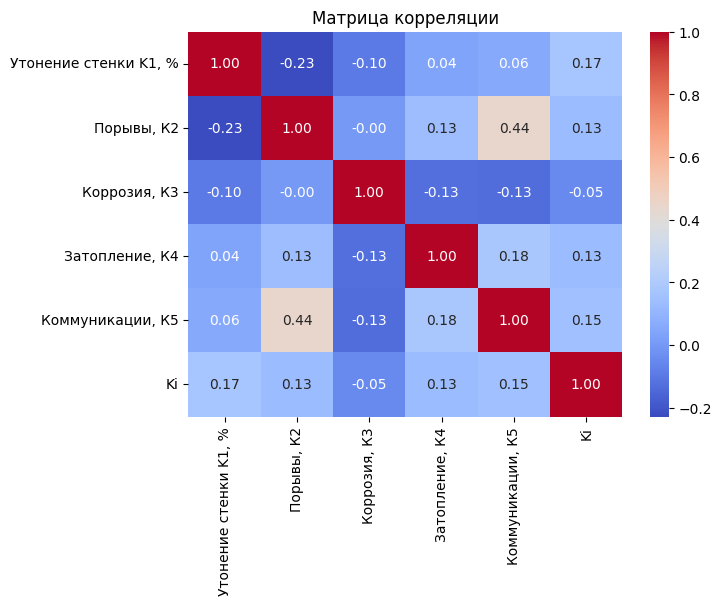

In [11]:
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Матрица корреляции')
plt.show()

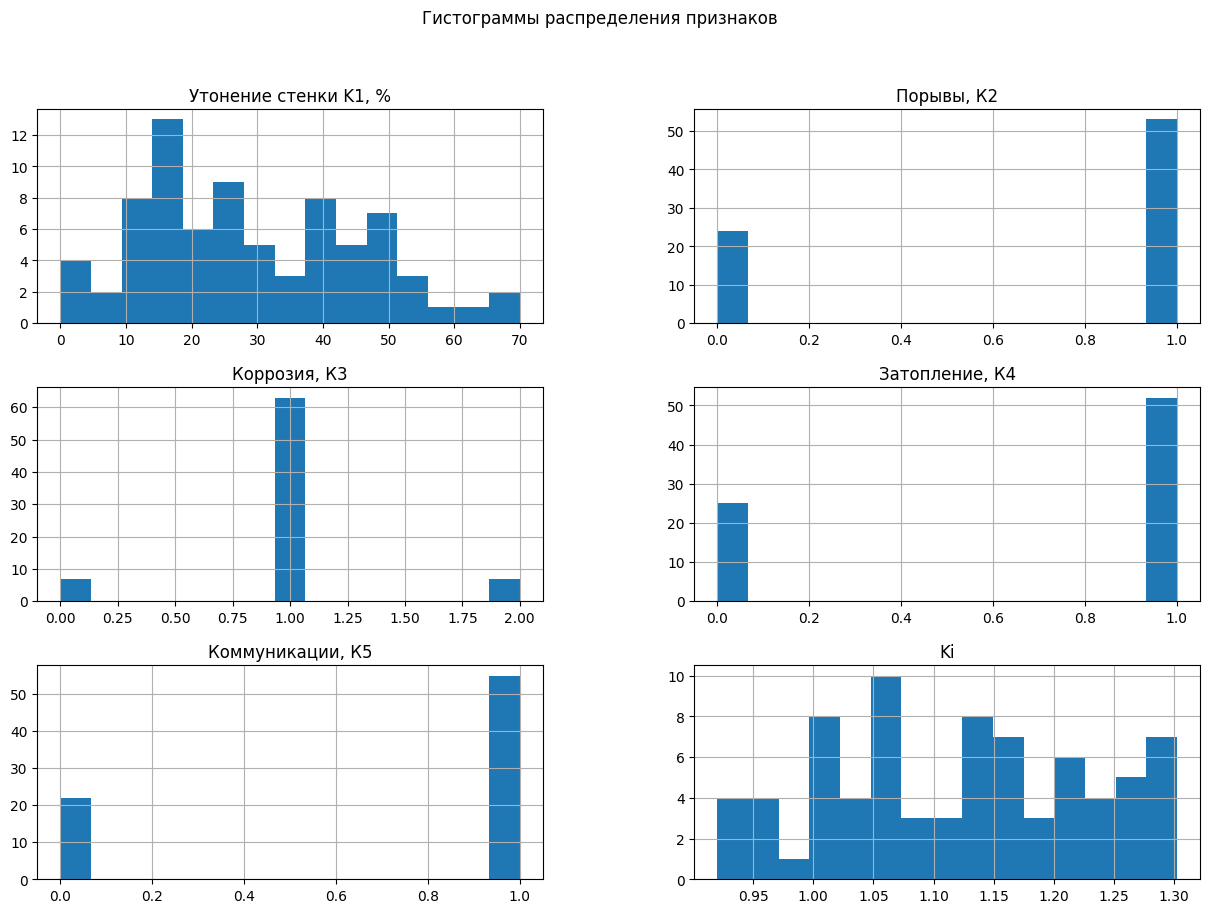

In [12]:
# Гистограммы для непрерывных признаков
df_common.hist(bins=15, figsize=(15, 10))
plt.suptitle('Гистограммы распределения признаков')
plt.show()

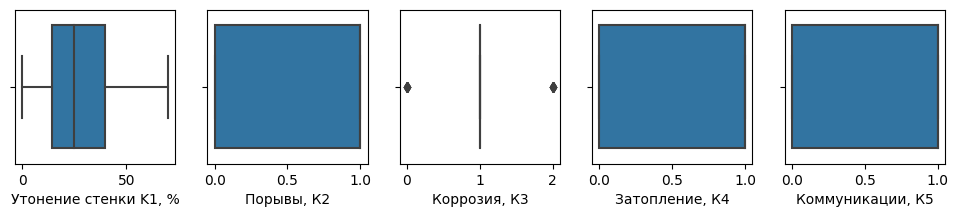

In [13]:
# Ящики с усами для категориальных признаков
plt.figure(figsize=(12, 2))
for index, feature in enumerate(["Утонение стенки K1, %", 
                                 "Порывы, К2", 
                                 "Коррозия, К3", 
                                 "Затопление, К4", 
                                 "Коммуникации, К5"]):
    plt.subplot(1, 5, index + 1)
    sns.boxplot(x=df_common[feature])
plt.tight_layout

X = df_common.drop('Ki', axis=1)  # 'y' замените на имя вашей целевой колонки
y = df_common['Ki']  # 'y' замените на имя вашей целевой колонки

# Обучение модели

## Tensorflow

In [31]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df_common)
# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Дополнительное разделение обучающего набора на обучающий и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mape', 'mse'])
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose = 0)

C:\Users\Nadezhda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Получение истории потерь и MAE
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

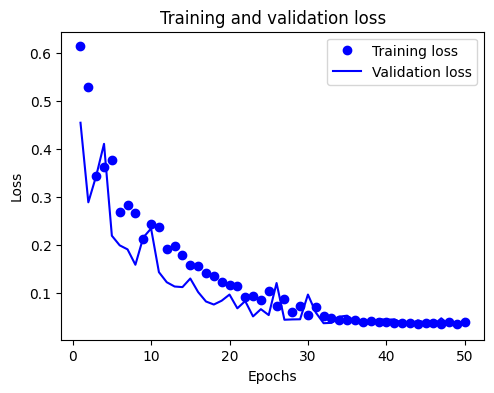

In [18]:
# График потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

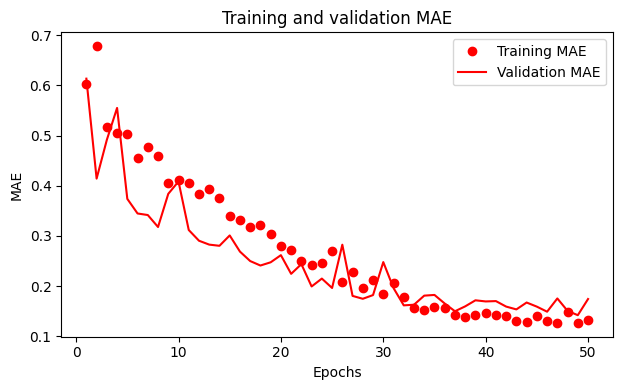

In [19]:
# График MAE
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'ro', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()

In [20]:
# Оценка производительности модели на тестовых данных
test_loss, test_mae, test_mape, test_mse = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}, Test MAE: {test_mae}, Test MAPE: {test_mape}, Test MSE: {test_mse}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0254 - mae: 0.0998 - mape: 9.3283 - mse: 0.0254
Test Loss: 0.025444043800234795, Test MAE: 0.09983895719051361, Test MAPE: 9.328277587890625, Test MSE: 0.025444043800234795


## Ensemble (GradientBoosting, RandomForest)

In [21]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())  # Изначально выбран Ridge, можно менять
])

# Параметры для GridSearchCV
params = {
    'regressor': [Lasso(), Ridge(), ElasticNet()],
    'regressor__alpha': [0.01, 0.1, 1, 10, 100],  # alpha - гиперпараметр для регуляризации
    # 'regressor__l1_ratio': [0.1, 0.5, 0.9]  # Только для ElasticNet
}

# Создание GridSearchCV
# Настройка GridSearchCV с несколькими метриками
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error'
}
grid = GridSearchCV(model, params, cv=5, scoring=scoring, refit='MAE', return_train_score=True)
grid.fit(X_train, y_train)

# Вывод результатов
best_params = grid.best_params_
best_score = -grid.best_score_

print("Лучшие параметры:", best_params)
print("Лучшая оценка (MAE):", best_score)

Лучшие параметры: {'regressor': Lasso(), 'regressor__alpha': 0.1}
Лучшая оценка (MAE): 0.09897476416054024


In [22]:
for scorer in scoring:
    key = f"mean_test_{scorer}"
    print(f"{scorer}: {-grid.cv_results_[key][grid.best_index_]}")

MAE: 0.09897476416054024
MAPE: 0.08980472849581274


In [23]:
# Пайплайн для Gradient Boosting
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor())
])

# Пайплайн для Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Параметры для GridSearchCV Gradient Boosting
gb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Параметры для GridSearchCV Random Forest
rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__max_depth': [5, 10, 15]
}

# Создание и выполнение GridSearchCV для Gradient Boosting
gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=5, scoring='neg_mean_absolute_percentage_error')
gb_grid.fit(X_train, y_train)

# Создание и выполнение GridSearchCV для Random Forest
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_absolute_percentage_error')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [5, 10, 15],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

In [24]:
# Вывод результатов для Gradient Boosting
print("Лучшие параметры для Gradient Boosting:", gb_grid.best_params_)
print("Лучшая оценка MAPE для Gradient Boosting:", -gb_grid.best_score_)

Лучшие параметры для Gradient Boosting: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Лучшая оценка MAPE для Gradient Boosting: 0.09442672948651222


In [25]:
# Вывод результатов для Random Forest
print("Лучшие параметры для Random Forest:", rf_grid.best_params_)
print("Лучшая оценка MAPE для Random Forest:", -rf_grid.best_score_)

Лучшие параметры для Random Forest: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 300}
Лучшая оценка MAPE для Random Forest: 0.09060261308404095


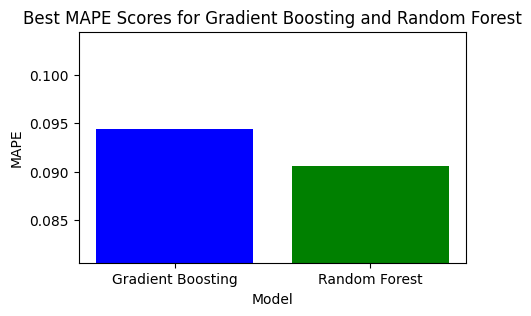

In [26]:
# Извлекаем лучшую модель
best_rf = rf_grid.best_estimator_.named_steps['regressor']
# Предполагаем, что вы уже имеете переменные gb_best_score и rf_best_score с результатами
models = ['Gradient Boosting', 'Random Forest']
mape_scores = [-gb_grid.best_score_, -rf_grid.best_score_]  # используйте реальные значения из вашего GridSearchCV

plt.figure(figsize=(5, 3))
plt.bar(models, mape_scores, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('Best MAPE Scores for Gradient Boosting and Random Forest')
plt.ylim(min(mape_scores) - 0.01, max(mape_scores) + 0.01)  # Небольшое пространство для лучшей визуализации
plt.show()

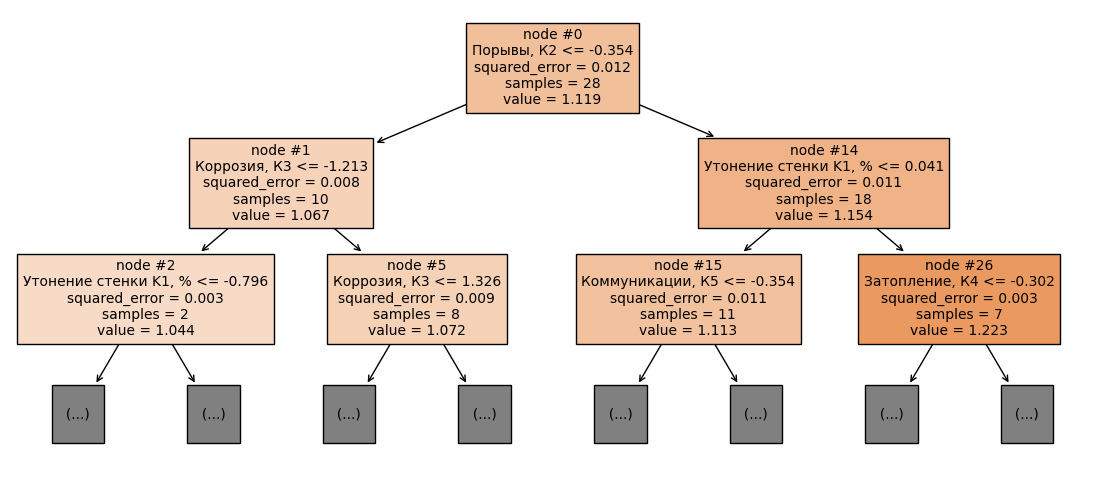

In [27]:
# Отрисовка первого дерева из лучшей модели
fig, ax = plt.subplots(figsize=(14, 6))
plot_tree(best_rf.estimators_[0], 
          filled=True, 
          feature_names=df_common.columns.tolist(), 
          ax=ax, 
          fontsize=10, 
          max_depth=2, 
          node_ids=True)
plt.show()

# Оценка ценности и фильтрация признаков

## GradientBoosting

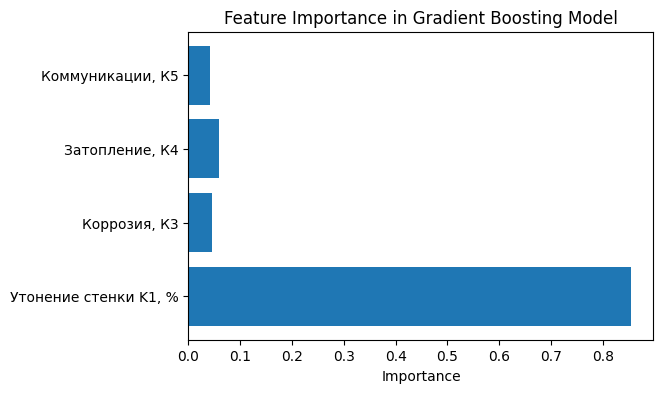

In [33]:
X_train = X_train.drop(['Порывы, К2'], axis=1)
X_test = X_test.drop(['Порывы, К2'], axis=1)

gb_model = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)
gb_model.fit(X_train, y_train)

# Вывод важности признаков
feature_importances = gb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(6, 4))
plt.barh(range(len(features)), feature_importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.title('Feature Importance in Gradient Boosting Model')
plt.show()
y_pred = gb_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [34]:
print(f'Mean Absolute Percentage Error (MAPE) on Test Set: {mape:.4f}')
print(f'Mean Absolute Error (MAE) on Test Set: {mae:.4f}')
print(f'Mean Squared Error (MSE) on Test Set: {mse:.4f}')

Mean Absolute Percentage Error (MAPE) on Test Set: 0.0579
Mean Absolute Error (MAE) on Test Set: 0.0648
Mean Squared Error (MSE) on Test Set: 0.0072


## RandomForest

In [55]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df_common)
# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Дополнительное разделение обучающего набора на обучающий и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

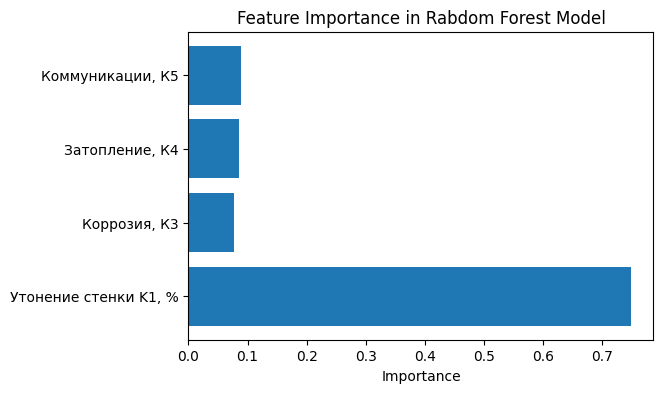

In [57]:
X_train = X_train.drop(['Порывы, К2'], axis=1)
X_test = X_test.drop(['Порывы, К2'], axis=1)

rf_model = RandomForestRegressor(max_depth=5, 
                                 n_estimators=300, 
                                 random_state=42, 
                                 max_features='sqrt')
rf_model.fit(X_train, y_train)

# Вывод важности признаков
feature_importances = rf_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(6, 4))
plt.barh(range(len(features)), feature_importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.title('Feature Importance in Rabdom Forest Model')
plt.show()
y_pred = rf_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [54]:
print(f'Mean Absolute Percentage Error (MAPE) on Test Set: {mape:.4f}')
print(f'Mean Absolute Error (MAE) on Test Set: {mae:.4f}')
print(f'Mean Squared Error (MSE) on Test Set: {mse:.4f}')

Mean Absolute Percentage Error (MAPE) on Test Set: 0.0600
Mean Absolute Error (MAE) on Test Set: 0.0653
Mean Squared Error (MSE) on Test Set: 0.0066
